In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# Corrected path (double backslashes or raw string format)
path = r"C:\Users\Sai Teja K\PycharmProjects\PythonProject\Autism-Image\AutismImageDataset"

# Check if the path exists
if os.path.exists(path):
    print("Directory contents:", os.listdir(path))
else:
    print(f"Error: Directory not found at {path}. Please check the path.")


Directory contents: ['.DS_Store', 'consolidated', 'input', 'test', 'train', 'valid']


In [2]:
# Define Constants
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
from tensorflow import keras

In [4]:
filenames = os.listdir(r"C:\Users\Sai Teja K\PycharmProjects\PythonProject\Autism-Image\AutismImageDataset\train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [5]:
df.head()

,filename,category
0,Autistic.0.jpg,1
1,Autistic.1.jpg,1
2,Autistic.10.jpg,1
3,Autistic.100.jpg,1
4,Autistic.1000.jpg,1


In [6]:
df.tail()

,filename,category
2535,Non_Autistic.995.jpg,0
2536,Non_Autistic.996.jpg,0
2537,Non_Autistic.997.jpg,0
2538,Non_Autistic.998.jpg,0
2539,Non_Autistic.999.jpg,0


<AxesSubplot:>

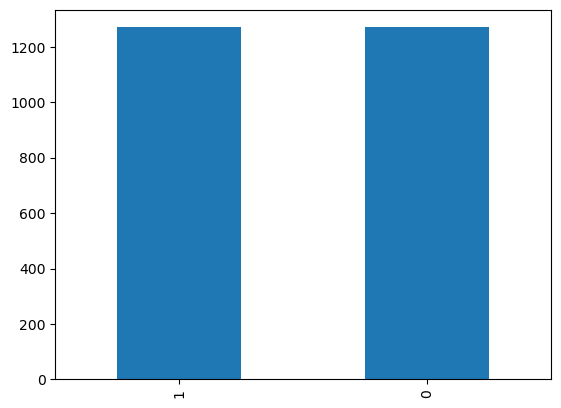

In [7]:
df['category'].value_counts().plot.bar()

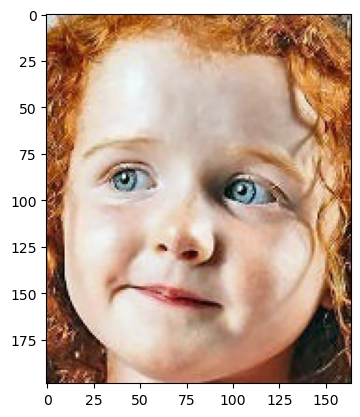

In [8]:
# See Sample Image
sample = random.choice(filenames)
image = load_img(r"AutismImageDataset/train/"+sample)
plt.imshow(image)

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define Image Dimensions
IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS = 224, 224, 3

# Load Pretrained Model as Feature Extractor
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
base_model.trainable = False  # Freeze base layers

# Build Model
model = Sequential([
    base_model,
    BatchNormalization(),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(2, activation='softmax')  # 2 classes: Autism / No Autism
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 1280)       5120      
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               32113152  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                      

In [35]:
# Callbacks
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [36]:
# # Early Stop
# earlystop = EarlyStopping(patience=10)

In [37]:
# # Learning Rate Reduction
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
#                                             patience=2,
#                                             verbose=1,
#                                             factor=0.5,
#                                             min_lr=0.00001)

In [38]:
# callbacks = [earlystop, learning_rate_reduction]

In [39]:
# Prepare Data
df["category"] = df["category"].replace({0: 'Non_Autistic', 1: 'Autistic'})

In [40]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

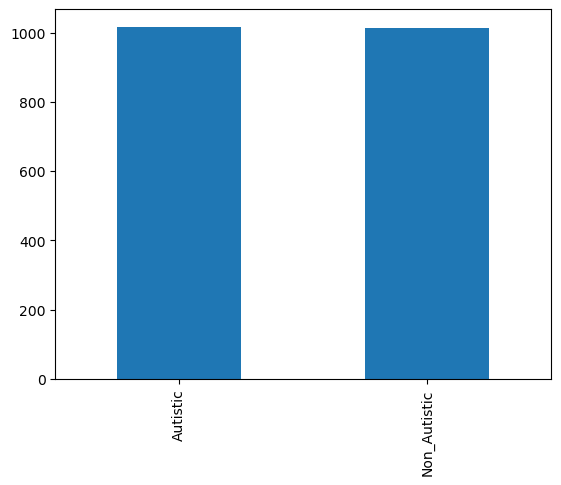

In [41]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

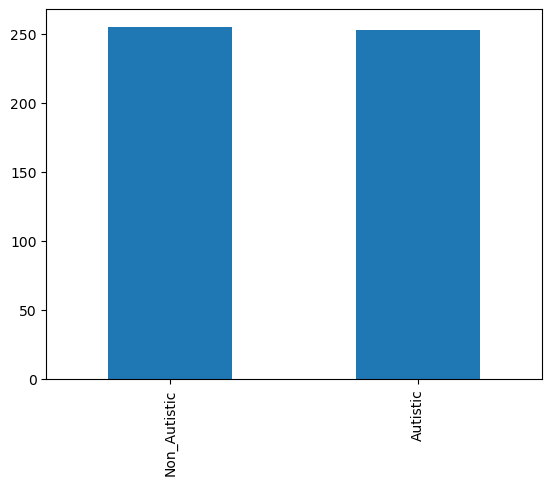

In [42]:
validate_df['category'].value_counts().plot.bar()

In [43]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [44]:
# Training Generator
train_datagen = ImageDataGenerator(
    rotation_range=10,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    r'C:\Users\Sai Teja K\PycharmProjects\PythonProject\Autism-Image\AutismImageDataset\train',
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2032 validated image filenames belonging to 2 classes.


In [45]:
# Validation Generator
IMAGE_SIZE = (128, 128)  # Ensure this matches the dataset image sizes
IMAGE_CHANNELS = 3  # 3 for RGB images


validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    r"C:\Users\Sai Teja K\PycharmProjects\PythonProject\Autism-Image\AutismImageDataset\train",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 508 validated image filenames belonging to 2 classes.


In [46]:
# Compile Model
optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)

In [47]:
# Train Model
history = model.fit(
    train_generator,
    epochs=150,
    validation_data=validation_generator,
    steps_per_epoch=total_train // batch_size,
    validation_steps=total_validate // batch_size,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/150


RuntimeError: pybind11::error_already_set: MISMATCH of original and normalized active exception types: ORIGINAL InvalidArgumentError REPLACED BY KeyboardInterrupt: <EMPTY MESSAGE>

At:
  D:\Anaconda\lib\site-packages\tensorflow\python\framework\errors_impl.py(273): __init__
  D:\Anaconda\lib\site-packages\tensorflow\python\eager\execute.py(52): quick_execute
  D:\Anaconda\lib\site-packages\tensorflow\python\eager\polymorphic_function\monomorphic_function.py(378): call
  D:\Anaconda\lib\site-packages\tensorflow\python\eager\polymorphic_function\monomorphic_function.py(1745): _call_flat
  D:\Anaconda\lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compiler.py(134): __call__
  D:\Anaconda\lib\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py(945): _call
  D:\Anaconda\lib\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py(880): __call__
  D:\Anaconda\lib\site-packages\tensorflow\python\util\traceback_utils.py(150): error_handler
  D:\Anaconda\lib\site-packages\keras\engine\training.py(1650): fit
  D:\Anaconda\lib\site-packages\keras\utils\traceback_utils.py(65): error_handler
  C:\Users\Sai Teja K\AppData\Local\Temp\ipykernel_15280\1651044125.py(2): <module>
  D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py(3457): run_code
  D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py(3377): run_ast_nodes
  D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py(3185): run_cell_async
  D:\Anaconda\lib\site-packages\IPython\core\async_helpers.py(78): _pseudo_sync_runner
  D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py(2960): _run_cell
  D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py(2914): run_cell
  D:\Anaconda\lib\site-packages\ipykernel\zmqshell.py(528): run_cell
  D:\Anaconda\lib\site-packages\ipykernel\ipkernel.py(390): do_execute
  D:\Anaconda\lib\site-packages\ipykernel\kernelbase.py(730): execute_request
  D:\Anaconda\lib\site-packages\ipykernel\kernelbase.py(406): dispatch_shell
  D:\Anaconda\lib\site-packages\ipykernel\kernelbase.py(499): process_one
  D:\Anaconda\lib\site-packages\ipykernel\kernelbase.py(510): dispatch_queue
  D:\Anaconda\lib\asyncio\events.py(80): _run
  D:\Anaconda\lib\asyncio\base_events.py(1905): _run_once
  D:\Anaconda\lib\asyncio\base_events.py(601): run_forever
  D:\Anaconda\lib\site-packages\tornado\platform\asyncio.py(199): start
  D:\Anaconda\lib\site-packages\ipykernel\kernelapp.py(712): start
  D:\Anaconda\lib\site-packages\traitlets\config\application.py(846): launch_instance
  D:\Anaconda\lib\site-packages\ipykernel_launcher.py(17): <module>
  D:\Anaconda\lib\runpy.py(87): _run_code
  D:\Anaconda\lib\runpy.py(197): _run_module_as_main


In [48]:
# Unfreeze base_model for fine-tuning
base_model.trainable = True
model.compile(optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue Training
history_finetune = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    steps_per_epoch=total_train // batch_size,
    validation_steps=total_validate // batch_size,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/50


KeyboardInterrupt: 

In [ ]:
model.save_weights("model.h5")
model.save('model.keras')

In [49]:
from keras.models import load_model
from tensorflow.keras.optimizers.experimental import AdamW
from keras.callbacks import ReduceLROnPlateau

# Load the previously trained model
model = load_model("model.keras")  

# Compile with a lower learning rate for fine-tuning
model.compile(
    loss='categorical_crossentropy',
    optimizer=AdamW(learning_rate=0.00005, weight_decay=0.0001),  # Lower LR for fine-tuning
    metrics=['accuracy']
)

# Reduce Learning Rate when validation accuracy stops improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Continue training from where it left off
epochs_remaining = 150 - 28  # Since previous training stopped at 28 epochs
history = model.fit(
    train_generator,
    epochs=epochs_remaining,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=[reduce_lr]  # Adjust learning rate dynamically
)

# Save the improved model
model.save("autism_cnn_model_finetuned.h5")


Epoch 1/122
  1/135 [..............................] - ETA: 5:28 - loss: 0.3941 - accuracy: 0.8667

KeyboardInterrupt: 

In [ ]:
model.save('model.keras')

NameError: name 'history' is not defined

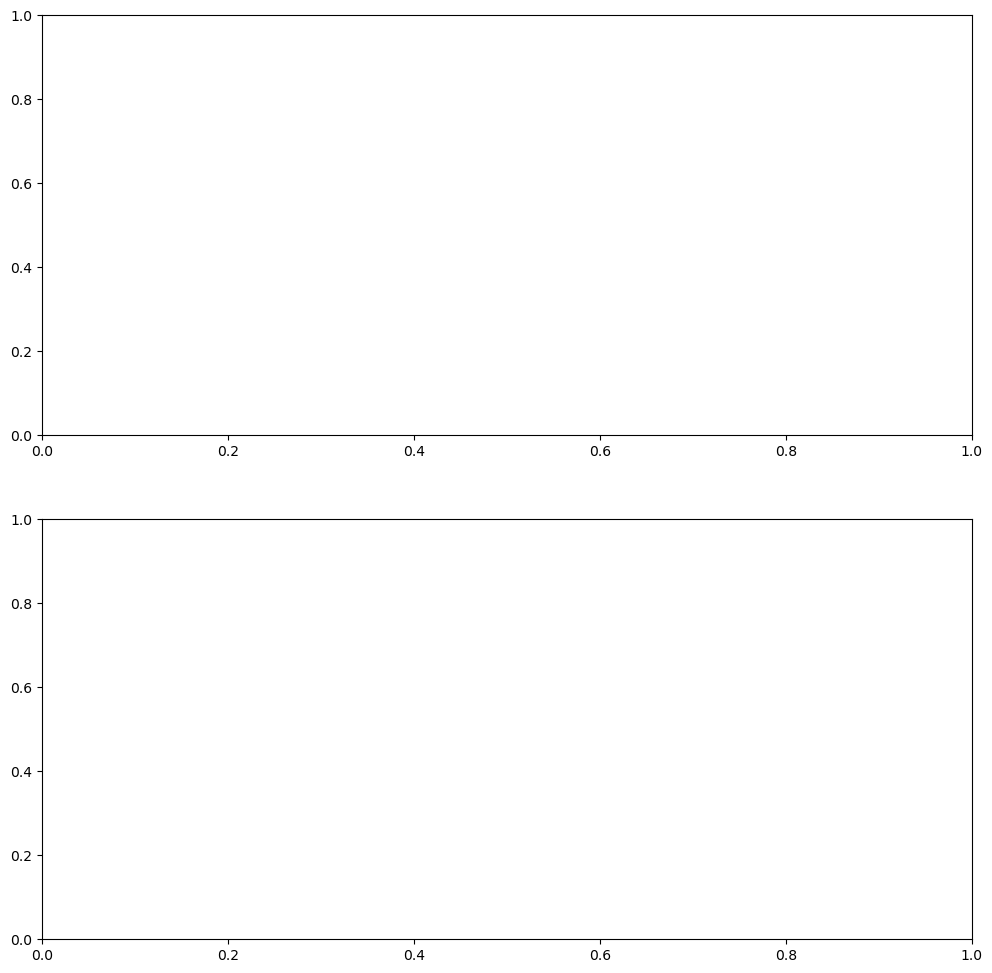

In [50]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [51]:
# Prepare Testing Data
test_filenames = os.listdir(r"C:\Users\Sai Teja K\PycharmProjects\PythonProject\Autism-Image\AutismImageDataset\test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [52]:
# Create Testing Generator
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    r"C:\Users\Sai Teja K\PycharmProjects\PythonProject\Autism-Image\AutismImageDataset\test",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 300 validated image filenames.


In [53]:
# Predict
# predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
steps=nb_samples/batch_size
predict = model.predict(test_generator, steps)

20/20 [==============================] - 5s 252ms/step


In [54]:
test_df['category'] = np.argmax(predict, axis=-1)

In [55]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [56]:
test_df['category'] = test_df['category'].replace({ 'Autistic': 1, 'Non_Autistic': 0 })

<AxesSubplot:>

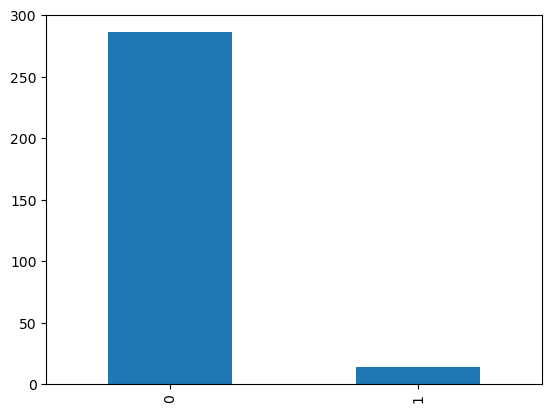

In [57]:
# Virtaulize Result
test_df['category'].value_counts().plot.bar()

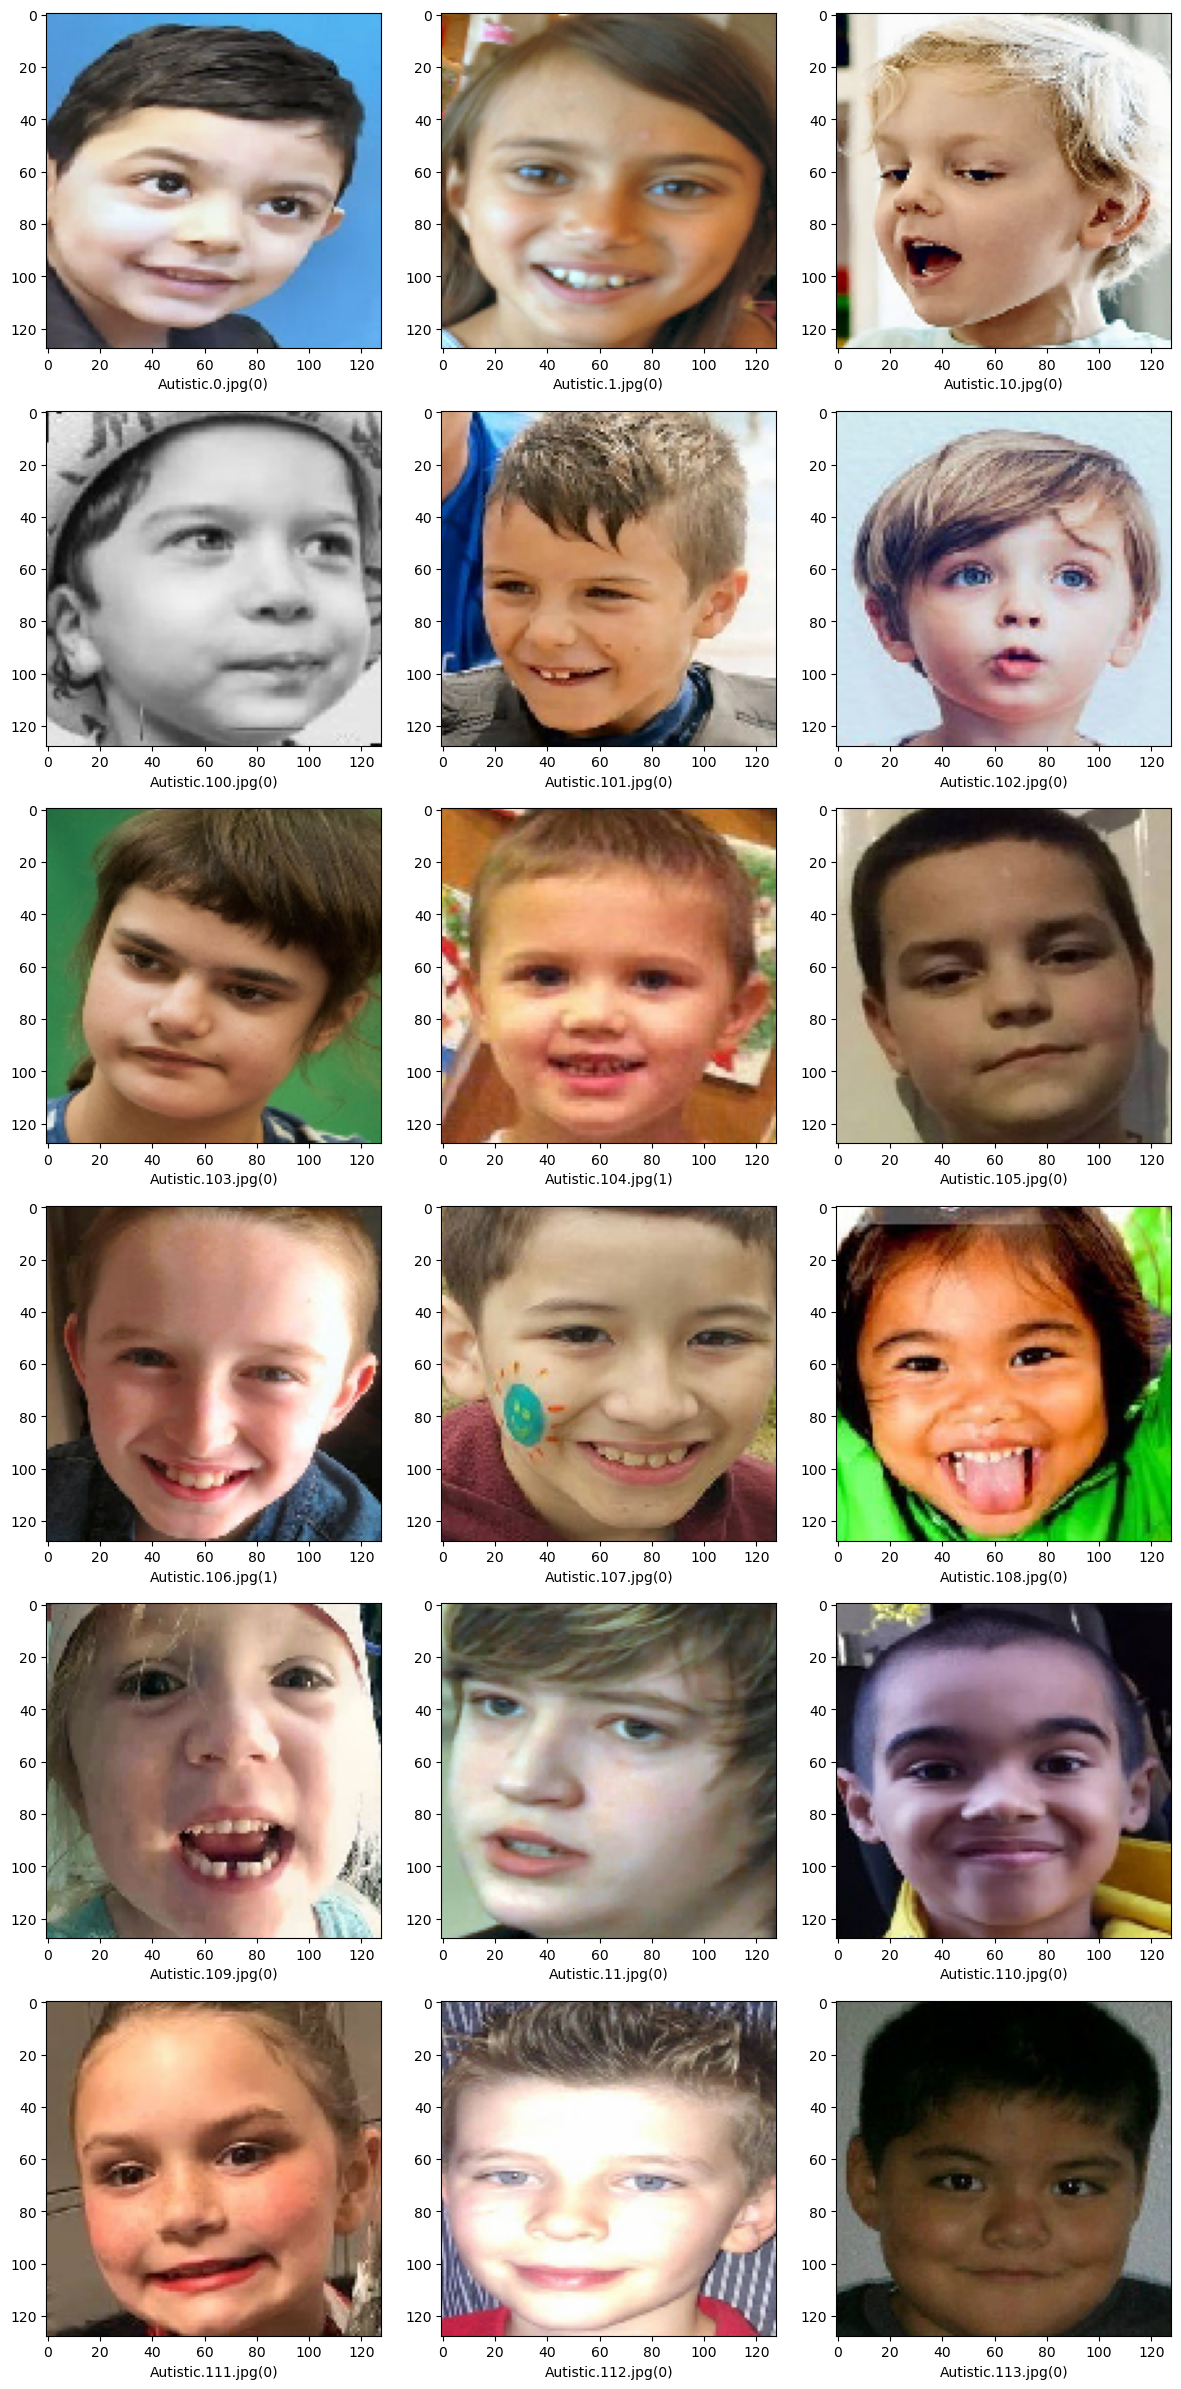

In [58]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(r"C:\Users\Sai Teja K\PycharmProjects\PythonProject\Autism-Image\AutismImageDataset\test\\" + filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 102ms/step
Predicted category: Non_Autistic
0.5433971


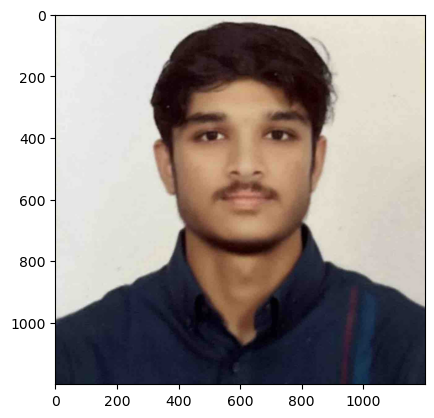

In [59]:
from PIL import Image
import numpy as np

# Function to preprocess the user-provided image
def preprocess_image(image_path, target_size):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.expand_dims(np.array(img) / 255.0, axis=0)  # Normalizing image
    return img_array

# Provide the path to the user-provided image
user_image_path = r"D:\College\LTI\passportsize_photo.jpg"


image = load_img(user_image_path)
plt.imshow(image)

# Preprocess the user-provided image
processed_image = preprocess_image(user_image_path, target_size=(128, 128))

# Use the trained model to predict the category of the image
prediction = model.predict(processed_image)

# Convert prediction to category label
predicted_category = 'Autistic' if prediction[0][1] > 0.6 else 'Non_Autistic'

print("Predicted category:", predicted_category)
print(prediction[0][1])

In [28]:
import tensorflow as tf

# Assuming 'model' is your trained CNN model
model.save("model.keras")

print("Model saved successfully!")


Model saved successfully!
